# Training cnn with in-memory generated BERT representations
Due to the extreme size of the token embeddings generated this way (512x768)

In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)
# for a gpu server
# print("Num GPUs Available: ", len(
#     tf.config.experimental.list_physical_devices('GPU')))

1.14.0


In [3]:
import os
import pdb
import pickle
from time import time

import bert
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from bert import modeling, tokenization
from keras import optimizers, regularizers
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import metrics
from average_precision import get_true_pred_topk
from bert_multilingual.bert_features import create_examples
from bert_multilingual.bert_model_utils import (
    file_based_convert_examples_to_features, file_based_input_fn_builder,
    model_fn_builder)
from utils import get_true_pred

Using TensorFlow backend.


In [4]:
# to reload the module during notebook runtime
import importlib
import metrics
importlib.reload(metrics)

<module 'metrics' from '/home/ianic/ma_thesis/hierarchical_multilabel_classifier/metrics.py'>

In [5]:
# data
df = pd.read_pickle("/home/ianic/ma_thesis/dataset_2_with_topics_prot_4.pkl")

LABEL_COLUMNS = list(df)[5:]
num_classes = len(LABEL_COLUMNS)

## BERT
### Define the model config and location of the pretrained model

In [6]:
base_path = ("/home/ianic/pretrain/multilingual_L-12_H-768_A-12")

BERT_VOCAB = base_path + '/bert_vocab.txt'
BERT_INIT_CHKPNT = base_path + '/bert_model.ckpt'
BERT_CONFIG = base_path + '/config.json'

MAX_SEQ_LENGTH = 512
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 12.0
# Warmup is a period of time where hte learning rate
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 500

tokenization.validate_case_matches_checkpoint(True, BERT_INIT_CHKPNT)
tokenizer = tokenization.FullTokenizer(
    vocab_file=BERT_VOCAB, do_lower_case=True)

## Load data and prepare examples in the specified format

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(
    df['clean_text'], df.iloc[:, 5:], test_size=0.2, random_state=42)
xtrain, xdev, ytrain, ydev = train_test_split(
    xtrain, ytrain, test_size=0.25, random_state=42)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
print(xtrain.shape, xdev.shape, ytrain.shape, ydev.shape)

df_train = pd.concat([xtrain, ytrain], axis=1, ignore_index=True)
df_val = pd.concat([xdev, ydev], axis=1, ignore_index=True)
df_test = pd.concat([xtest, ytest], axis=1, ignore_index=True)
print(f"train shape: {df_train.shape}")
print(f"val shape: {df_val.shape}")
print(f"test shape: {df_test.shape}")

(23445,) (7816,) (23445, 214) (7816, 214)
(23445,) (7816,) (23445, 214) (7816, 214)
train shape: (23445, 215)
val shape: (7816, 215)
test shape: (7816, 215)


In [10]:
def create_input_fn_from_examples(examples, force_build_tfrecord=False, stage='train'):
    input_file = os.path.join(
        '/home/ianic/pretrain/working', f"bert_{stage}.tf_record")
    if not os.path.exists(input_file) or force_build_tfrecord:
        open(input_file, 'w').close()
        # generate train tf.record data if needed
        tfrecord_time_start = time()
        file_based_convert_examples_to_features(
            examples, MAX_SEQ_LENGTH, tokenizer, input_file)
        print(f"Finished generating {stage} set tf.record",
              f"in {time()-tfrecord_time_start} seconds.")

    input_fn = file_based_input_fn_builder(
        input_file=input_file,
        seq_length=MAX_SEQ_LENGTH,
        is_training=False,
        drop_remainder=False,
        len_labels=len(LABEL_COLUMNS))

    return input_fn

In [11]:
train_examples = create_examples(df_train)
dev_examples = create_examples(df_val)
test_examples = create_examples(df_test)

train_input_fn = create_input_fn_from_examples(
    train_examples, force_build_tfrecord=False, stage='train')
dev_input_fn = create_input_fn_from_examples(
    dev_examples, force_build_tfrecord=False, stage='dev')
test_input_fn = create_input_fn_from_examples(
    test_examples, force_build_tfrecord=False, stage='test')

## Initialize the model

In [12]:
OUTPUT_DIR = "./working/output"
# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    keep_checkpoint_max=1,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Define BERT layers which will be taken into account for
# data representation
layer_indexes = [-1, -2, -3, -4]

# '512x768' - return the sum of the specified layers
# '4x512x768' - return the layers as-is
MODE = '512x768'

In [13]:
bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG)
model_fn = model_fn_builder(
    bert_config=bert_config,
    num_labels=len(LABEL_COLUMNS),
    init_checkpoint=BERT_INIT_CHKPNT,
    learning_rate=LEARNING_RATE,
    num_train_steps=-1,
    num_warmup_steps=-1,
    use_tpu=False,
    use_one_hot_embeddings=False,
    layer_indexes=layer_indexes
)

estimator = tf.estimator.Estimator(
    model_fn=model_fn,
    config=run_config,
    params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': './working/output', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3380e30850>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [14]:
def generate_bert_embeddings(input_fn, embeddings_list, label_ids_list):
    cnt = 0
    for result in tqdm(estimator.predict(input_fn, yield_single_examples=True)):
        out = {}
        ids = result["input_ids"]
        label_ids = result["label_ids"]
        tokens = tokenizer.convert_ids_to_tokens(ids)

        embeddings = []
        for (i, token) in enumerate(tokens):
            layers = []
            for (j, layer_index) in enumerate(layer_indexes):
                layer_output = result["layer_output_%d" % j]
                layer_output_flat = np.array(
                    [x for x in layer_output[i:(i + 1)].flat])
                layers.append(layer_output_flat)
            if MODE == '512x768':
                embeddings.append(sum(layers))  # 768 x 512
            elif MODE == '4x512x768':
                embeddings.append((token, layers))  # 4 x 768 x 512

        embeddings_list[cnt] = embeddings
        label_ids_list[cnt] = label_ids

        if (cnt < 1):
            if MODE == '512x768':
                print(f"token: {token}, shape[1]: ",  # 0,1 - first embed, 0 is token
                      f"{len(embeddings), len(embeddings[0])}, types: {type(layers[0][0])}")
            elif MODE == '4x512x768':
                print(f"token: {token}, shape[1]: ",  # 0,1 - first embed, 0 is token
                      f"{len(embeddings), len(embeddings[0][1])}, types: {type(layers[0][0])}")
            print(f"label_ids: {len(label_ids)}")
        cnt += 1

    return embeddings_list, label_ids_list

In [15]:
embeddings_list = np.empty([23445, 512, 768])
# for two-file output
label_ids_list = np.empty([23445, 214])

embeddings_list, label_ids_list = generate_bert_embeddings(
    train_input_fn, embeddings_list, label_ids_list)

In [16]:
print(f"Embedding list size: {len(embeddings_list)}")
print(f"Labels list size: {len(label_ids_list)}")
print(
    f"Embedding size: {len(embeddings_list[0][0])}, {len(embeddings_list[0])}")

embeddings_list size: 23445
label_ids_list size: 23445
embedding size: 768, 512


In [17]:
dev_embeddings_list = np.empty([7816, 512, 768])
# for two-file output
dev_label_ids_list = np.empty([7816, 214])

generate_bert_embeddings(dev_input_fn, dev_embeddings_list, dev_label_ids_list)

In [18]:
print(f"dev_embeddings_list size: {len(dev_embeddings_list)}")
print(f"dev_label_ids_list size: {len(dev_label_ids_list)}")
print(
    f"embedding size: {len(dev_embeddings_list[0][0])}, {len(dev_embeddings_list[0])}")

dev_embeddings_list size: 7816
dev_label_ids_list size: 7816
embedding size: 768, 512


In [19]:
test_embeddings_list = np.empty([7816, 512, 768])
# for two-file output
test_label_ids_list = np.empty([7816, 214])

generate_bert_embeddings(
    test_input_fn, test_embeddings_list, test_label_ids_list)

In [20]:
print(f"test_embeddings_list size: {len(test_embeddings_list)}")
print(f"test_label_ids_list size: {len(test_label_ids_list)}")
print(
    f"embedding size: {len(test_embeddings_list[0][0])}, {len(test_embeddings_list[0])}")

test_embeddings_list size: 7816
test_label_ids_list size: 7816
embedding size: 768, 512


In [21]:
# embeddings
print(np.asarray(embeddings_list).shape)
print(np.asarray(dev_embeddings_list).shape)
# labels
print(np.asarray(label_ids_list).shape)
print(np.asarray(dev_label_ids_list).shape)

(23445, 512, 768)
(7816, 512, 768)
(23445, 214)
(7816, 214)


## CNN
Model definition and training

In [22]:
# training params
batch_size = 128
num_epochs = 8

# model parameters
num_filters = 64
input_len = 512
embed_dim = 768
weight_decay = 1e-4

In [23]:
# CNN architecture

# The inputs are BERT token embeddings 512 tokens x 768 dimensions
# and the batch size is 128
input_shape = (batch_size, 512, 768, 1)

model = Sequential()
model.add(Conv2D(filters=num_filters, kernel_size=(5, 768),
                 activation='relu', padding='valid',
                 input_shape=input_shape[1:4]
                 ))
model.add(MaxPooling2D(pool_size=(508, 1)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',
                kernel_regularizer=regularizers.l2(weight_decay)))
# multi-label (k-hot encoding)
model.add(Dense(num_classes, activation='sigmoid'))
model.add(Flatten(input_shape=(1, 214)))

adam = optimizers.Adam(lr=0.001, beta_1=0.9,
                       beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [24]:
def batch_generator(x, y, batch_size, steps):
    idx = 1
    while True:
        _x = np.expand_dims(x[(idx-1)*128: idx*128], axis=3)
        _y = y[(idx-1)*128: idx*128]
        yield (_x, _y)
        if idx < steps:
            idx += 1
        else:
            idx = 1

In [25]:
steps_per_epoch = np.ceil(23445/batch_size)
validation_steps = np.ceil(7816/batch_size)
test_steps = validation_steps

# Generator objects for train and validation seta
training_batch_generator = batch_generator(
    embeddings_list, label_ids_list, batch_size, steps_per_epoch)
validation_batch_generator = batch_generator(
    dev_embeddings_list, dev_label_ids_list, batch_size, validation_steps)
test_batch_generator = batch_generator(
    test_embeddings_list, test_label_ids_list, batch_size, test_steps)

In [26]:
model.fit_generator(training_batch_generator,
                    epochs=num_epochs,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=validation_steps)

Epoch 1/8
184/184 [==============================] - 145s 789ms/step - loss: 0.1054 - acc: 0.9677 - val_loss: 0.0445 - val_acc: 0.9891
Epoch 2/8
184/184 [==============================] - 160s 871ms/step - loss: 0.0459 - acc: 0.9890 - val_loss: 0.0364 - val_acc: 0.9901
Epoch 3/8
184/184 [==============================] - 109s 592ms/step - loss: 0.0380 - acc: 0.9898 - val_loss: 0.0335 - val_acc: 0.9904
Epoch 4/8
184/184 [==============================] - 105s 570ms/step - loss: 0.0334 - acc: 0.9905 - val_loss: 0.0316 - val_acc: 0.9908
Epoch 5/8
184/184 [==============================] - 113s 613ms/step - loss: 0.0310 - acc: 0.9909 - val_loss: 0.0309 - val_acc: 0.9908
Epoch 6/8
184/184 [==============================] - 109s 595ms/step - loss: 0.0294 - acc: 0.9911 - val_loss: 0.0302 - val_acc: 0.9910
Epoch 7/8
184/184 [==============================] - 105s 568ms/step - loss: 0.0285 - acc: 0.9913 - val_loss: 0.0298 - val_acc: 0.9910
Epoch 8/8
184/184 [==============================] - 10

In [28]:
prediction = model.predict(np.expand_dims(dev_embeddings_list, axis=3))

In [29]:
# load the class hierarchy
ch = None
with open('../ch.pickle', 'rb') as f:
    ch = pickle.load(f)

In [30]:
# generate label predictions for MAP@K
labels_true_topk, labels_pred_topk = get_true_pred_topk(
    LABEL_COLUMNS, prediction, dev_label_ids_list, 5)

true: ['MEDIJI|TELEVIZIJA', 'PRAVOSUĐE/SUDSTVO/KRIMINAL|KRIMINAL', 'ZDRAVLJE|MEDICINSKO OSOBLJE']
pred: ['PRAVOSUĐE/SUDSTVO/KRIMINAL|KRIMINAL', 'ZDRAVLJE|BOLESTI', 'ZANIMLJIVOSTI|ŽIVOTINJE', 'ZDRAVLJE|MEDICINA', 'ZDRAVLJE|Veterina']


In [31]:
# generate label predictions for the given threshold
labels_true, labels_pred = get_true_pred(
    LABEL_COLUMNS, prediction, dev_label_ids_list, 0.5)

In [32]:
metrics.classification_report(ch, labels_true, labels_pred)

=PRECISION==================================================
precision_anc : 0.5781745935599545
precision_desc: 0.4909302883791105
precision_brnc: 0.5765549088460243
=RECALL==================================================
recall_anc : 0.7175331509155967
recall_desc: 0.6640230044988636
recall_brnc: 0.7022703969532738
=F1==================================================
f1_score_anc : 0.6403595867435932
f1_score_desc: 0.5645059537891333
f1_score_brnc: 0.633233394529341
=EXACT MATCH==================================================
exact match accuracy: 0.49232421942682886
scikit exact match accuracy: 0.086489252814739


In [33]:
metrics.classification_report_topk(ch, labels_true_topk, labels_pred_topk, 1)
metrics.classification_report_topk(ch, labels_true_topk, labels_pred_topk, 3)
metrics.classification_report_topk(ch, labels_true_topk, labels_pred_topk, 5)

K =: 1
MAP anc + : 0.513689866939611
MAP anc: 0.46430399181166837
mapk : 0.7561412487205732
K =: 3
MAP anc + : 0.37329409757761856
MAP anc: 0.3268828897987035
mapk : 0.6352318605709087
K =: 5
MAP anc + : 0.40473213778005235
MAP anc: 0.3328832949505288
mapk : 0.6494650218924143


## Threshold optimization
I optimise the decision threshold with regard to the f1-score

In [34]:
def optimize_threshold_for_f1(yval, y_pred_prob, labels):
    t_s = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
           0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    t_vals_micro = list(map(lambda x: f1_score(yval, (y_pred_prob >= x).astype(int),
                                               average="micro"), t_s))
    t_vals_macro = list(map(lambda x: f1_score(yval, (y_pred_prob >= x).astype(int),
                                               average="macro"), t_s))

    fig, ax = plt.subplots()
    for Y in [t_vals_macro, t_vals_micro]:
        ax.plot(t_s, Y)
    plt.show()

    opt_threshold = t_s[np.argmax(t_vals_macro)]
    return opt_threshold, t_vals_macro, t_vals_micro

/home/ianic/.conda/envs/tf_old/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


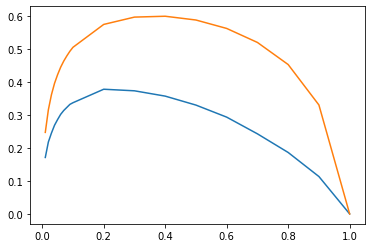

t_s: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
f1 macro: [0.17090494381338064, 0.21769378777100576, 0.24472228215630124, 0.2683342855129051, 0.2856112228779379, 0.3014109821492567, 0.31303805741619806, 0.32229162833137986, 0.33154246894455036, 0.3365692635426212, 0.3774010054899524, 0.3726507920173707, 0.3565624824753756, 0.32942997141495783, 0.29295513406610857, 0.2423932488336335, 0.1859803995067877, 0.1131569393583293, 0.0]
(0.2, [0.17090494381338064, 0.21769378777100576, 0.24472228215630124, 0.2683342855129051, 0.2856112228779379, 0.3014109821492567, 0.31303805741619806, 0.32229162833137986, 0.33154246894455036, 0.3365692635426212, 0.3774010054899524, 0.3726507920173707, 0.3565624824753756, 0.32942997141495783, 0.29295513406610857, 0.2423932488336335, 0.1859803995067877, 0.1131569393583293, 0.0])


In [35]:
opt_threshold = optimize_threshold_for_f1(
    dev_label_ids_list, prediction, LABEL_COLUMNS)
print(opt_threshold)